In [10]:
# PART 1: Downloading and Cleaning
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("AmesHousing.csv", index_col=0)

# Identify unnamed columns and PID to drop
unnamed_cols = [col for col in df.columns if 'unnamed' in col.lower() or 'no meaning' in col.lower()]
columns_to_drop = unnamed_cols + ['PID']

# Drop identified columns
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

print(f"Dropped {len(unnamed_cols)} unnamed columns and PID")
print(f"DataFrame shape: {df_cleaned.shape}")
print("Note: Target creation and splitting moved to Part 2 to prevent data leakage.")

Dropped 0 unnamed columns and PID
DataFrame shape: (2930, 80)
Note: Target creation and splitting moved to Part 2 to prevent data leakage.


In [11]:
# Part 2 Missing Value Imputation

# Show the number of missing values before we start
print("Missing values before imputation:")
print(df_cleaned.isnull().sum().sort_values(ascending=False).head(10))
print("-" * 30)

# Drop rows where the dependent variable is missing
DV = 'SalePrice'
df_sample1 = df_cleaned.dropna(subset=[DV]).copy() # Use .copy() to avoid warnings

# --- 1. Impute "Meaningful NA" Categoricals ---
# These are columns where 'NA' is a category (e.g., "No Basement"), not missing data.
meaningful_na_columns = [
    'Alley', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 
    'BsmtFin Type 1', 'BsmtFin Type 2', 'FireplaceQu',
    'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond',
    'Pool QC', 'Fence', 'Misc Feature', 'Mas Vnr Type'
]

for col in meaningful_na_columns:
    if col in df_sample1.columns:
        df_sample1[col] = df_sample1[col].fillna('None')

# --- 2. Numerical Imputation ---
# We create df_sample2 by filling all numerical NAs
df_sample2 = df_sample1.copy()

# A. Smart Imputation (Context-Aware): Fill with 0
# If a house has no basement, its basement-related numericals should be 0, not a median.

# Basement-related numericals, if there is no Basement, then the other Basement columns get 0.
if 'Bsmt Qual' in df_sample2.columns:
    mask = (df_sample2['Bsmt Qual'] == 'None')
    bsmt_num_cols = ['Total Bsmt SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
    for col in bsmt_num_cols:
        if col in df_sample2.columns:
            df_sample2.loc[mask, col] = df_sample2.loc[mask, col].fillna(0)

# Garage-related numericals: If there is no Garage, then the other Garage columns get 0.
if 'Garage Type' in df_sample2.columns:
    mask = (df_sample2['Garage Type'] == 'None')
    garage_num_cols = ['Garage Cars', 'Garage Area', 'Garage Yr Blt']
    for col in garage_num_cols:
        if col in df_sample2.columns:
            df_sample2.loc[mask, col] = df_sample2.loc[mask, col].fillna(0)

# Masonry veneer numericals. If there is no Masonry Veneer Numerical, then the other Masonry columns get 0.
if 'Mas Vnr Type' in df_sample2.columns:
    mask = (df_sample2['Mas Vnr Type'] == 'None')
    if 'Mas Vnr Area' in df_sample2.columns:
         df_sample2.loc[mask, 'Mas Vnr Area'] = df_sample2.loc[mask, 'Mas Vnr Area'].fillna(0)
 
# 'Lot Frontage' is likely similar for houses in the same 'Neighborhood', so I use the group median of lot frontage for the neighborhood to impute..
if 'Lot Frontage' in df_sample2.columns and 'Neighborhood' in df_sample2.columns:
    # Fill NAs with the median Lot Frontage of that specific neighborhood
    df_sample2['Lot Frontage'] = df_sample2.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(x.median()))
    # If any NAs remain (e.g., a whole neighborhood was NA), fill with the overall median
    df_sample2['Lot Frontage'] = df_sample2['Lot Frontage'].fillna(df_sample2['Lot Frontage'].median())

# C. Generic Median Imputation (Fallback)
# Now, find ALL remaining numerical columns and fill them with their median.
# This will handle columns like 'Lot Area' and any NAs our previous logic missed.
all_numerical_cols = df_sample2.select_dtypes(include=np.number).columns
df_sample2[all_numerical_cols] = df_sample2[all_numerical_cols].fillna(value=df_sample2[all_numerical_cols].median())


# --- 3. Categorical Imputation ---
# We create df_sample4 by filling all remaining categorical NAs
df_sample4 = df_sample2.copy()


# B. Generic Mode Imputation (Fallback)
# Find ALL remaining categorical/object columns and fill with their mode.
all_categorical_cols = df_sample4.select_dtypes(include=['object', 'category']).columns

for col in all_categorical_cols:
     df_sample4[col] = df_sample4[col].fillna(df_sample4[col].mode()[0])


# --- 4. Final Check ---
# This command should now return 0. There should now be no missing values in our dataset.
total_missing = df_sample4.isnull().sum().sum()
print("-" * 30)
print(f"Total missing values remaining in df_sample4: {total_missing}")



Missing values before imputation:
Pool QC          2917
Misc Feature     2824
Alley            2732
Fence            2358
Mas Vnr Type     1775
Fireplace Qu     1422
Lot Frontage      490
Garage Cond       159
Garage Yr Blt     159
Garage Finish     159
dtype: int64
------------------------------
------------------------------
Total missing values remaining in df_sample4: 0


In [12]:
# Part 3 Variable transformation

# Below our two lists that encapsulate all columns in the dataset. 
# We will dummify the categorical variables and standardize the numerical variables.

nvar_list_original = [
    'Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
    'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
    'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
    '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
    'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Bsmt Full Bath',
    'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
    'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Mo Sold', 'Yr Sold', 'SalePrice'
]

cvar_list_original = [
    'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
    'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
    'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
    'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature',
    'Sale Type', 'Sale Condition', 
    'Lot Shape', 'Utilities', 'Land Slope', 'Exter Qual', 'Exter Cond',
    'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
    'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu',
    'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence'
]


# Make a dataset of our dependent and indepedent variables and
# standardize the numerical variables using the formula
model_cols = cvar_list_original + nvar_list_original
df_sample5 = df_sample4[model_cols].copy()
df_sample5[nvar_list_original] = (df_sample4[nvar_list_original] - df_sample4[nvar_list_original].mean())/df_sample4[nvar_list_original].std()

# Set the datatype for the variables in the cvar_list to be categorical in Python
# Set the datatype for the variables in the nvar_list to be numerical in Python 
df_sample6 = df_sample5.copy()
df_sample6[cvar_list_original] = df_sample5[cvar_list_original].astype('category')
df_sample6[nvar_list_original] = df_sample5[nvar_list_original].astype('float64')

# Convert the categorical variables into dummies (Step 1 of dummy coding)
df_sample7 = df_sample6.copy()
df_sample7 = pd.get_dummies(df_sample6, prefix_sep='_', dtype=int)

# Remove redundant dummies automatically (drop the mode category per categorical variable)
# (Step 2 of dummy coding)
df_sample8 = df_sample7.copy()

# For each categorical variable, drop the dummy corresponding to its most frequent category
for var in cvar_list_original:
    mode_value = df_sample4[var].mode()[0]  # get the most frequent category
    dummy_col = f"{var}_{mode_value}"       # build dummy column name
    if dummy_col in df_sample8.columns:
        df_sample8 = df_sample8.drop(columns=[dummy_col])
        print(f"Dropped redundant dummy: {dummy_col}")

# Check resulting columns
print("\nRemaining columns after dummy reduction:")
print(df_sample8.columns.values)

# Get the remaining variable list after the variable transformation
print(df_sample8.columns.values)

# Display the milestone dataframe. Compare it with the original dataframe.
print(df_sample8)
print(df)

Dropped redundant dummy: MS SubClass_20
Dropped redundant dummy: MS Zoning_RL
Dropped redundant dummy: Street_Pave
Dropped redundant dummy: Alley_None
Dropped redundant dummy: Land Contour_Lvl
Dropped redundant dummy: Lot Config_Inside
Dropped redundant dummy: Neighborhood_NAmes
Dropped redundant dummy: Condition 1_Norm
Dropped redundant dummy: Condition 2_Norm
Dropped redundant dummy: Bldg Type_1Fam
Dropped redundant dummy: House Style_1Story
Dropped redundant dummy: Roof Style_Gable
Dropped redundant dummy: Roof Matl_CompShg
Dropped redundant dummy: Exterior 1st_VinylSd
Dropped redundant dummy: Exterior 2nd_VinylSd
Dropped redundant dummy: Mas Vnr Type_None
Dropped redundant dummy: Foundation_PConc
Dropped redundant dummy: Heating_GasA
Dropped redundant dummy: Central Air_Y
Dropped redundant dummy: Garage Type_Attchd
Dropped redundant dummy: Misc Feature_None
Dropped redundant dummy: Sale Type_WD 
Dropped redundant dummy: Sale Condition_Normal
Dropped redundant dummy: Lot Shape_Reg
D

In [13]:
# Our DV is InBudget_Not in Budget   (1 = Not in Budget, 0 = In Budget)


Median Sale Price (Training Data): -0.21650740014417916
       SalePrice  InBudget_Not in Budget
Order                                   
1130    0.620278                       1
2102    0.242155                       1
234     0.615922                       1
2035   -0.498156                       0
1959   -0.473121                       0


c:\Users\jmart0509\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


                             0
Lot Area              0.641928
Overall Qual          1.176485
Year Built            0.977035
Total Bsmt SF         0.455874
Gr Liv Area           1.296545
Full Bath             0.291127
Garage Cars           0.390118
Mas Vnr Area          0.057665
1st Flr SF            0.027315
Neighborhood_Blmngtn  0.000000
Neighborhood_Blueste  0.000000
Neighborhood_BrDale   0.000000
Neighborhood_BrkSide  0.000000
Neighborhood_ClearCr  0.000000
Neighborhood_CollgCr  0.000000
Neighborhood_Crawfor  0.671949
Neighborhood_Edwards  0.000000
Neighborhood_Gilbert  0.038439
Neighborhood_Greens   0.000000
Neighborhood_GrnHill  0.000000
Neighborhood_IDOTRR   0.000000
Neighborhood_Landmrk  0.000000
Neighborhood_MeadowV  0.000000
Neighborhood_Mitchel  0.000000
Neighborhood_NPkVill  0.000000
Neighborhood_NWAmes   0.000000
Neighborhood_NoRidge  0.000000
Neighborhood_NridgHt  0.000000
Neighborhood_OldTown  0.000000
Neighborhood_SWISU    0.000000
Neighborhood_Sawyer   0.000000
Neighbor

c:\Users\jmart0509\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\jmart0509\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


                             0
Lot Area              0.341125
Overall Qual          1.068307
Year Built            0.792406
Total Bsmt SF         0.685811
Gr Liv Area           1.475695
Full Bath             0.424247
Garage Cars           0.455758
Mas Vnr Area          0.118284
1st Flr SF            0.093501
Neighborhood_Blmngtn  0.000000
Neighborhood_Blueste  0.664473
Neighborhood_BrDale   0.000000
Neighborhood_BrkSide  0.532838
Neighborhood_ClearCr  1.321801
Neighborhood_CollgCr -0.062536
Neighborhood_Crawfor  2.030515
Neighborhood_Edwards -0.746145
Neighborhood_Gilbert  0.458395
Neighborhood_Greens   1.138733
Neighborhood_GrnHill  0.406680
Neighborhood_IDOTRR  -0.460222
Neighborhood_Landmrk  0.000000
Neighborhood_MeadowV -0.385193
Neighborhood_Mitchel  0.172691
Neighborhood_NPkVill -0.722367
Neighborhood_NWAmes   0.172975
Neighborhood_NoRidge  0.000000
Neighborhood_NridgHt  0.732659
Neighborhood_OldTown -0.857503
Neighborhood_SWISU    0.000000
Neighborhood_Sawyer   0.011822
Neighbor

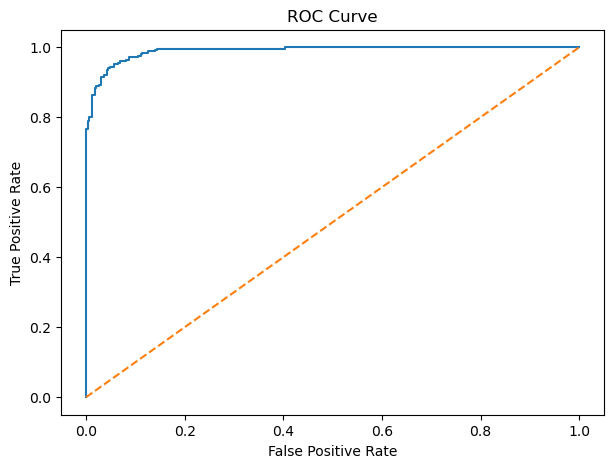

In [ ]:
# Part 5 Data Partition, Logistic Regression (Train/test, CV, and ROC/AUC)

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define the final lists of model columns

# List of your 10 numerical variables
nvar_list = [
    'Lot Area', 'Overall Qual', 'Year Built', 'Total Bsmt SF', 'Gr Liv Area',
    'Full Bath', 'Garage Cars', 'Mas Vnr Area', '1st Flr SF', 
]

# List of your final dummy variables 
# REMOVED 'InBudget_Not in Budget' here because we create it later
cvar_list = [
    'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale',
    'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
    'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
    'Neighborhood_Greens', 'Neighborhood_GrnHill', 'Neighborhood_IDOTRR',
    'Neighborhood_Landmrk', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
    'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
    'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
    'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
    'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
    'House Style_1.5Fin', 'House Style_1.5Unf', 'House Style_2.5Fin',
    'House Style_2.5Unf', 'House Style_2Story', 'House Style_SFoyer',
    'House Style_SLvl', 'Bldg Type_2fmCon', 'Bldg Type_Duplex',
    'Bldg Type_Twnhs', 'Bldg Type_TwnhsE', 'Kitchen Qual_Ex', 'Kitchen Qual_Fa',
    'Kitchen Qual_Gd', 'Kitchen Qual_Po', 'Exter Qual_Ex', 'Exter Qual_Fa',
    'Exter Qual_Gd', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_Slab',
    'Foundation_Stone', 'Foundation_Wood'
]

# Combine lists to get all model columns
# ADDED 'SalePrice' so it is available for the calculation
model_columns = nvar_list + cvar_list + ['SalePrice']


# Select only the model columns from df_sample8 for partitioning
df4partition = df_sample8[model_columns]


# test_size specifies the percentage for the test partition
testpart_size = 0.2

# random_state specifies the seed for random number generator. 
# random_state = 1 unless otherwised noted
df_nontestData, df_testData = train_test_split(df4partition, test_size=testpart_size, random_state=1)

# --- CALCULATE MEDIAN ON TRAINING SET ONLY ---

# 1. Calculate the median Sale Price strictly from the training set
train_median = df_nontestData['SalePrice'].median()
print(f"Median Sale Price (Training Data): {train_median}")

# 2. Create the DV column for the Training Set
# Logic: If Price > Median, it is 'Not in Budget' (1), else 0
df_nontestData['InBudget_Not in Budget'] = (df_nontestData['SalePrice'] > train_median).astype(int)

# 3. Create the DV column for the Test Set
# IMPORTANT: We use the 'train_median' to label the test set to ensure consistency
df_testData['InBudget_Not in Budget'] = (df_testData['SalePrice'] > train_median).astype(int)

print(df_nontestData[['SalePrice', 'InBudget_Not in Budget']].head())

# ---------------------------------------------

DV = "InBudget_Not in Budget"

y = df_nontestData[DV]
# Drop DV AND SalePrice from predictors so the model doesn't cheat
X = df_nontestData.drop(columns=[DV, 'SalePrice'])

y_test = df_testData[DV]
# Drop DV AND SalePrice from predictors
X_test = df_testData.drop(columns=[DV, 'SalePrice'])

from sklearn.linear_model import LogisticRegression

# Fixed alpha (penalty strength). 
alpha = 10
clf = LogisticRegression(
    C=1/alpha,
    penalty='l1',
    solver='saga',
    max_iter=200,
    random_state=1
).fit(X, y)

import pandas as pd

def summary_coef(model_object):
    n_predictors = X.shape[1]
    model_coef = pd.DataFrame(
        model_object.coef_.reshape(1, n_predictors),
        columns=X.columns.values
    )
    model_coef['Intercept'] = model_object.intercept_
    return model_coef.transpose()

print(summary_coef(clf))

from sklearn.linear_model import LogisticRegressionCV
import numpy as np

kfolds = 5

# Search range for penalty (like his notes)
min_alpha = 0.01
max_alpha = 100
n_candidates = 300

C_list = list(1/np.linspace(min_alpha, max_alpha, num=n_candidates))

clf_optimal = LogisticRegressionCV(
    Cs=C_list,
    cv=kfolds,
    penalty='l1',
    solver='saga',
    max_iter=500,
    random_state=1,
    n_jobs=-1
).fit(X, y)

print(summary_coef(clf_optimal))
print("\nOptimal alpha:", 1/clf_optimal.C_)

from sklearn import metrics

y_test_pred = clf_optimal.predict(X_test)

print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_test_pred))

print("\nAccuracy:", clf_optimal.score(X_test, y_test))

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_test_prob = clf_optimal.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_test_prob)
print("AUC:", auc)

fpr, tpr, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()